In [1]:
# Logistic Regression

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import mean
from numpy import std
import pandas as pd
from collections import Counter

from sklearn import preprocessing, svm
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.metrics import accuracy_score

from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
#from hyperopt import tpe, STATUS_OK, Trials, hp, fmin, STATUS_OK, space_eval

In [3]:
columns_new=['Site', 
             'EVI (3 Years Before)', 'NDVI (3 Years Before)', 'FPAR (3 Years Before)', 'LAI (3 Years Before)', 
          'LST Day (3 Years Before)', 'LST Night (3 Years Before)', 'EVI (2 Years Before)', 'NDVI (2 Years Before)', 
          'FPAR (2 Years Before)', 'LAI (2 Years Before)', 'LST Day (2 Years Before)','LST Night (2 Years Before)', 
          'EVI (1 Year Before)', 'NDVI (1 Year Before)', 'FPAR (1 Year Before)', 'LAI (1 Year Before)', 
          'LST Day (1 Year Before)', 'LST Night (1 Year Before)',
       'LATITUDE', 'LONGITUDE', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'Date', '_classes']

In [4]:
variable = [
            'geopotential', 'relative_humidity', 'temperature',
            'u component of wind', 'v component of wind',
        ]
pressure_level = [
             '300', '500', '700', '850']

_columns = []
for i in pressure_level:
    for j in variable:
        _columns.append(i + ': ' + j)

In [5]:
df1 = pd.read_csv("Data/wildfire_classes2.csv").dropna()
df1.columns = columns_new

df_rad = pd.read_csv("wf_era5.csv").dropna().iloc[:, 1:21]
df_rad.columns = _columns

df2 = pd.concat([df1.iloc[:, :-6], df_rad, df1.iloc[:, -6:]], axis = 1)

In [6]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on your data
scaler.fit(df2.iloc[:, 1:-6])

# Transform your DataFrame
scaled_df = scaler.transform(df2.iloc[:, 1:-6])

# Convert the scaled array back to a DataFrame
scaled_df = pd.DataFrame(scaled_df, columns=df2.iloc[:, 1:-6].columns)

In [7]:
scaled_df = pd.concat([df2.iloc[:, :1], df2.iloc[:, 1:-6], df2.iloc[:, -6:]], axis = 1)

In [8]:
df = scaled_df.sample(frac = 1)

In [9]:
df

,Site,EVI (3 Years Before),NDVI (3 Years Before),FPAR (3 Years Before),LAI (3 Years Before),LST Day (3 Years Before),LST Night (3 Years Before),EVI (2 Years Before),NDVI (2 Years Before),FPAR (2 Years Before),...,850: relative_humidity,850: temperature,850: u component of wind,850: v component of wind,LATITUDE,LONGITUDE,FIRE_SIZE,FIRE_SIZE_CLASS,Date,_classes
1452,SWL28,-0.033368,-0.071349,-0.081618,-0.344490,5.920874,3.923883,-0.033679,-0.070160,-0.068158,...,289.702047,-2.455352,-1.758061,15194.11015,31.502222,-109.083611,16802.00,4,3/1/2009,1
1888,RMS23,0.060199,0.081087,0.018958,-0.052916,12.022097,6.921022,0.051541,0.070392,0.003245,...,274.234942,5.007515,-3.663458,15185.22902,39.613056,-99.182500,289.00,3,11/18/2005,0
2047,SAD3,-0.096682,-0.153222,0.009223,0.177436,-20.897783,-4.959474,-0.021572,-0.069585,-0.036594,...,277.721154,1.324440,3.072731,15373.72771,37.339840,-83.408280,275.00,3,2/29/2004,0
1650,AKC6,-0.082871,-0.153898,-0.092407,-0.414698,-8.730788,-7.198534,-0.086032,-0.155303,-0.121330,...,283.569558,1.670159,-0.657699,14201.33804,67.487200,-145.144700,98.00,2,7/6/2007,0
310,SWG14,0.037212,0.058698,-0.019593,-0.105100,10.468129,8.433708,0.034695,0.051724,-0.029008,...,292.936505,1.218748,-1.878225,14725.85537,31.570800,-108.685800,61620.00,4,4/22/2018,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1484,GBG76,-0.001061,0.021317,0.153082,0.345982,-12.588870,-4.529473,-0.001316,0.025143,0.176917,...,296.280831,2.403116,1.501013,14669.87631,45.540556,-114.509444,5311.00,4,7/18/2008,1
1004,SAL7,-0.043600,-0.042059,-0.052630,-0.349759,-4.277618,-4.180519,-0.058361,-0.062521,-0.070536,...,298.834851,0.527018,6.783393,14693.85222,36.158889,-96.940556,6887.00,4,8/4/2012,1
1783,SWB9,0.032892,0.126989,0.098286,0.524986,1.651806,2.454430,0.040580,0.139188,0.140634,...,293.791435,0.381106,0.319248,15317.26400,33.162630,-93.493350,9.00,1,7/15/2006,0
1998,NWB16,0.118342,0.255398,0.223228,0.548773,-9.877772,-5.969475,0.118111,0.265839,0.237583,...,297.902914,0.729366,-0.929391,14908.11314,44.455830,-121.571610,9.70,1,8/13/2004,0


In [10]:
xlist = df.columns[1:-4]
ylist = ['_classes']

In [11]:
X = df.loc[:, xlist]
y = df.loc[:, ylist]

In [12]:
from sklearn.linear_model import LogisticRegression
train_index1 = []
test_index1 = []
train = []
acc = []
feat = []
kf = KFold(n_splits=10, shuffle = True, random_state = 44)
kf.get_n_splits(X)
for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    
    X_test = X.iloc[test_index]
    y_test = y.iloc[test_index]
    
    clf = LogisticRegression()
    clf.fit(X_train, y_train.values)
    
    train.append(clf.score(X_train, y_train))
    train_index1.append(train_index)
    test_index1.append(test_index)
    
    y_pred = clf.predict(X_test)
    
    #sel = SelectFromModel(clf)
    #sel.fit(X_train, y_train.values.ravel())
    #print(sel.get_support())
    #selected_feat = X_train.columns[(sel.get_support())]
    #feat += selected_feat.values.tolist()
    #print(selected_feat.values)
    
    acc.append(accuracy_score(y_pred , y_test))

print("Test Max ", max(acc))
#print("Corresponding Train ", train[acc.index(max(acc))])
#print("Train Index ", train_index1[acc.index(max(acc))])
#print("Test Index ", test_index1[acc.index(max(acc))])
print("Test Mean ", mean(acc))

C:\Users\nagra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\nagra\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\nagra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example us

Test Max  0.7524271844660194
Test Mean  0.6985436893203884


C:\Users\nagra\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\nagra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\nagra\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example us

In [13]:
acc

[0.6407766990291263,
 0.7087378640776699,
 0.6893203883495146,
 0.7330097087378641,
 0.7233009708737864,
 0.7524271844660194,
 0.6699029126213593,
 0.6796116504854369,
 0.6796116504854369,
 0.7087378640776699]

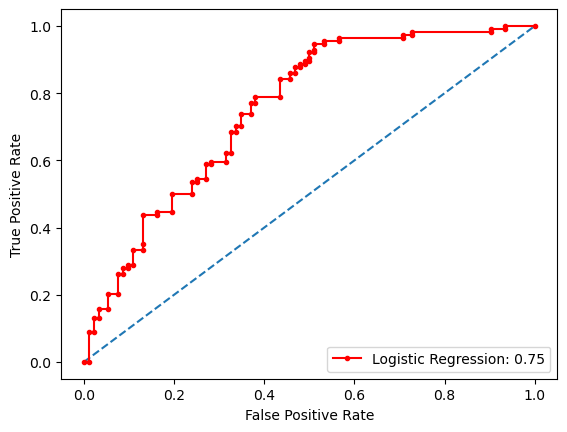

In [14]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

ns_probs = [0 for _ in range(len(y_test))]
lr_probs = clf.predict_proba(X_test)
lr_probs = lr_probs[:, 1]
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

pyplot.plot(ns_fpr, ns_tpr, linestyle='--')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Regression: ' + str(lr_auc)[:4], color = 'red')

pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

# show the legend
pyplot.legend(loc = 'lower right')
# show the plot
pyplot.show()

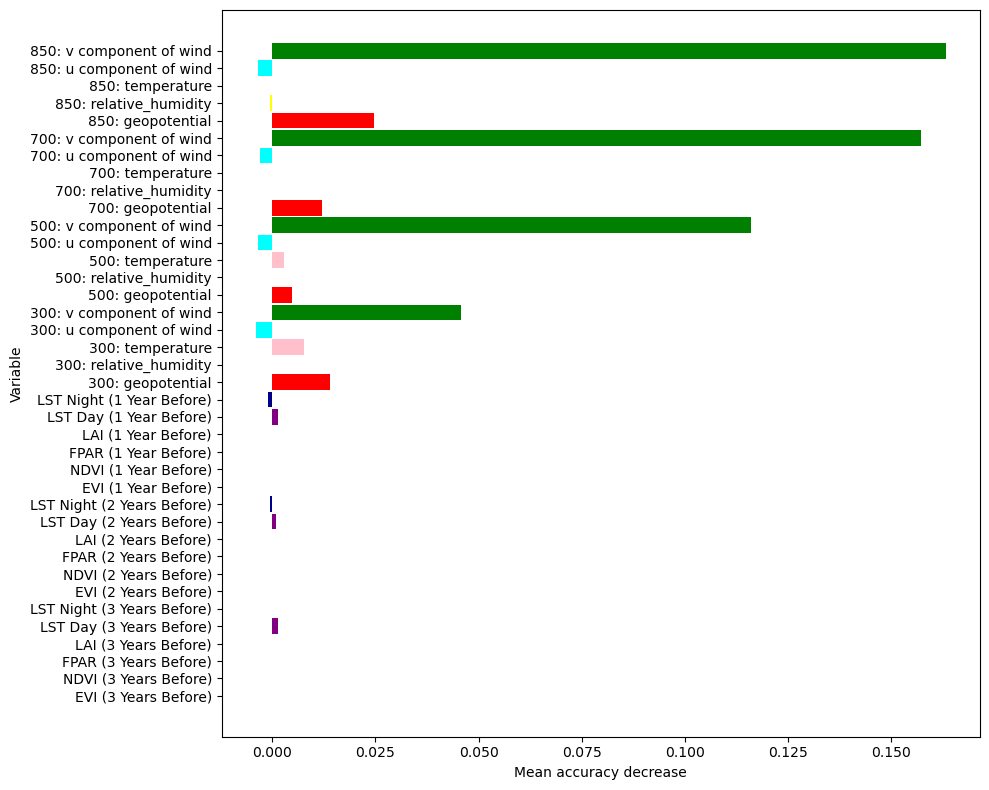

In [15]:
from sklearn.inspection import permutation_importance
colors = ['khaki', 'brown', 'olive', 'orange', 'purple', 'darkblue']*3 + ['red', 'yellow', 'pink', 'cyan', 'green']*5
Labels = xlist[0:-2]

result = permutation_importance(
    clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
forest_importances = pd.Series(result.importances_mean[0:-2], index=Labels)

#fig, ax = plt.subplots()
#ax.barh(Labels, feat_importances, color = colors, height = 0.9)
#ax.set_xlabel('Feature Importance (MDI)')
#ax.set_ylabel('Variable')
#plt.show()

fig, ax = plt.subplots(figsize = (10,8))
ax.barh(Labels, forest_importances, color = colors, height = 0.9)
#forest_importances.plot.barh(yerr=result.importances_std, ax=ax, color = colors)
ax.set_xlabel("Mean accuracy decrease")
ax.set_ylabel("Variable")
fig.tight_layout()
plt.show()

In [16]:
import itertools
def generate_confusion_matrix(cnf_matrix, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.get_cmap('Reds'))
    #plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=12)
    plt.yticks(tick_marks, classes, rotation=90, ha = 'center', va='center', fontsize=12)

    fmt = '.2f' if normalize else 'd'
    thresh = cnf_matrix.max() /(1.5)

    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt), horizontalalignment="center", fontsize=20,
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)

    return cnf_matrix

Normalized confusion matrix


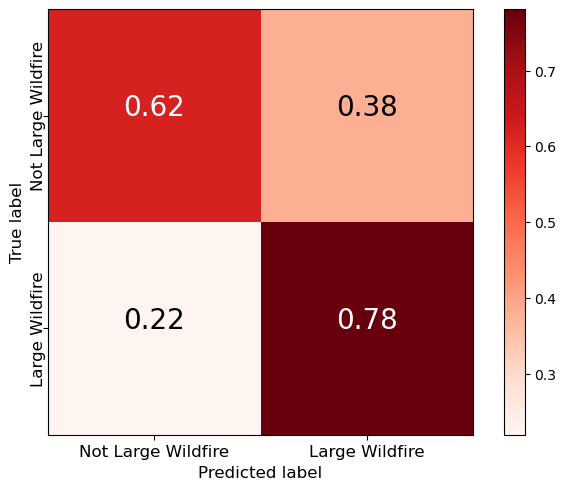

In [17]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
class_names = ["Not Large Wildfire", "Large Wildfire"]

# Plot normalized confusion matrix
plt.figure()
generate_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()